# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [1]:
#Загрузим библиотеку, не входящую во многие распространенные сборки
!pip install category_encoders
!pip install imbalanced-learn

In [2]:
# Загрузим необходимые библиотеки
from category_encoders import TargetEncoder
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures

In [3]:
pd.options.mode.chained_assignment = None
import warnings
warnings.filterwarnings('ignore', '.*One or more .*', )

In [4]:
# Загрузим данные и посмотрим первые строки
df = pd.read_csv('/datasets/Churn.csv')

df.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


Итак, первый взгляд на данные позволяет сделать несколько выводов.
Во-первых, столбцы названы не в змеином стиле. На исследование это, конечно, не влияет, но переименуем их, чтобы было привычней.
Во-вторых, есть несколько столбцов, которые едва ли могут повлиять на оценку вероятности ухода клиента из банка. Это «RowNumber», «CustomerId», «Surname». Их удалим.
Теоретически по столбцу «Surname» можно определить с определенной долей уверенности национальность клиента, однако это не так просто, а влияние этого возможного признака на точность модели может оказаться минимальным. По этой причине это поле все же удалено.


In [5]:
# Заменим названия столбцов
df.columns = ['row_number', 'customer_id', 'surname', 'credit_score', 'geography', 'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card', 'is_active_member', 'estimated_salary', 'exited']

In [6]:
# Удалим ненужные столбцы
df = df.drop(['row_number', 'customer_id', 'surname'], axis=1)

Теперь проверим типы оставшихся столбцов и полноту данных

In [7]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      10000 non-null  int64  
 1   geography         10000 non-null  object 
 2   gender            10000 non-null  object 
 3   age               10000 non-null  int64  
 4   tenure            9091 non-null   float64
 5   balance           10000 non-null  float64
 6   num_of_products   10000 non-null  int64  
 7   has_cr_card       10000 non-null  int64  
 8   is_active_member  10000 non-null  int64  
 9   estimated_salary  10000 non-null  float64
 10  exited            10000 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


У нас есть 10 столбцов с признаками и один – с целевым показателем. Отсутствующие данные есть лишь в столбце «tenure». Одна из следующих задач – попытаться выяснить причины пропусков и выбрать способ работы с ними.
Также мы видим две категориальные переменные – «geography» и «gender». Их преобразуем прямым кодированием.
Заметим, что тип int64 явно излишен для многих столбцов. В данном случае преобразовывать типы не будем, так как набор данных маленький и в будущем, возможно, потребуется масштабирование признаков.


In [8]:
# посмотрим, есть ли что-то особенное в наблюдениях, где не заполнен столбец "tenure"
df[df['tenure'].isna()].head(15)

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
30,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0
82,543,France,Female,36,NaN,0.00,2,0,0,26019.59,0
85,652,Spain,Female,75,NaN,0.00,2,1,1,114675.75,0
94,730,Spain,Male,42,NaN,0.00,2,0,1,85982.47,0
99,413,France,Male,34,NaN,0.00,2,0,0,6534.18,0
111,538,Germany,Male,39,NaN,108055.10,2,1,0,27231.26,0


Полученные примеры не позволяют определить закономерности в появлении пропусков. Проверим, возможно интересующий нас столбец имеет сильную связь с каким-то другим признаком в наборе.

In [9]:
df.corrwith(df['tenure'])

C:\Users\User\AppData\Local\Temp\ipykernel_18100\3697804709.py:1: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corrwith(df['tenure'])


credit_score       -0.000062
age                -0.013134
tenure              1.000000
balance            -0.007911
num_of_products     0.011979
has_cr_card         0.027232
is_active_member   -0.032178
estimated_salary    0.010520
exited             -0.016761
dtype: float64

Весьма красноречиво! Линейных связей нет. Заместим отсутствующие данные медианой. Этот вариант позволяет сохранить данные и минимизировать влияние на работу модели.

In [10]:
df['tenure'] = df['tenure'].fillna(df['tenure'].median())

Далее посмотрим на связь между имеющимися признаками на основе матрицы корреляции. При этом важно помнить, что часть признаков имеет явно бинарный характер.

C:\Users\User\AppData\Local\Temp\ipykernel_18100\2953211560.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr().round(2), annot=True);


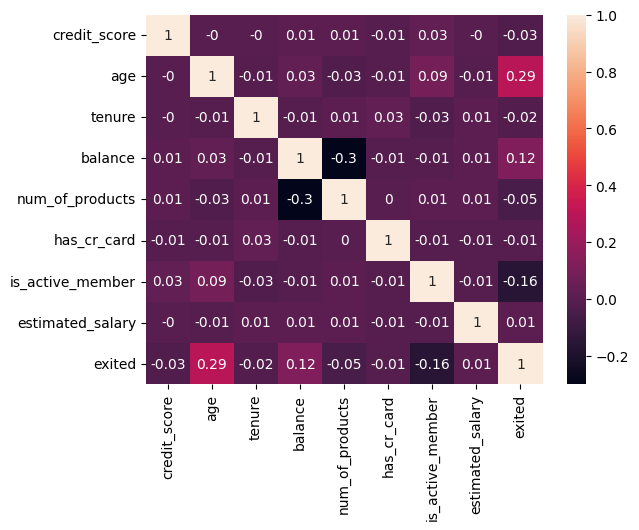

In [11]:

sns.heatmap(df.corr().round(2), annot=True);

Коэффициенты корреляции не демонстрируют значимые линейные связи между показателями. Соответственно, нет никаких оснований удалять те или иные столбцы.
Теперь проверим таблицу на наличие явных дубликатов, а затем посмотрим основные характеристики имеющихся признаков.


In [12]:
df.duplicated().sum()

0

In [13]:
df.describe()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
count,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,4.99790,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.76001,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.00000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.00000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.00000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.00000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.00000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


Главная особенность в данных – серьезный дисбаланс целевого показателя. Это важно для формирования тестовой выборки, создания модели.
В остальном ничего примечательного в данных не заметно. Большие хвосты есть в возрасте, но ничего удивительного в них нет.
Выделим признаки и целевой показатель, разделим данные на обучающую и тестовую выборки. Также необходимо перекодировать категориальные признаки. Это мы сделаем позднее, так как в пайплане можно будет попробовать разные варианты кодировки.


In [14]:
# Отделяем признаки от целевого показателя
features = df.drop('exited', axis=1)
target = df['exited']

In [15]:
# Отделяем 20 % выборки для будущих тестов

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=12345, stratify=target)

In [16]:
# Проверим размеры наборов
print(features_train.shape, features_test.shape, target_train.shape, target_test.shape)

(8000, 10) (2000, 10) (8000,) (2000,)


*Выводы*
Нам удалось загрузить и познакомиться с данными. Были найдены 3 столбца, которые в дальнейшем не понадобятся. Их мы удалили. Также был найден столбец с пропусками. Для пропущенных данных в качестве значения установлена медиана, что позволило не терять данные и минимизировать влияние на результаты моделей. Корреляции между признаками не обнаружено.
Переходим к обучению первых моделей.


## Исследование задачи

На этом этапе мы попробуем обучить разные модели, не учитывая несбалансированность целевого показателя. Тестовую выборку оставим на будущее, при неообходимости используя кросс-валидацию. 
Сначала посмотрим, каково качество модели, случайно предсказывающей ответы.


In [17]:
model = DummyClassifier(strategy='uniform')
model.fit(features_train, target_train)
print('f1_score', f1_score(target_train, model.predict(features_train)))
print('roc_auc_score', roc_auc_score(target_train, model.predict(features_train)))

f1_score 0.28319856244384545
roc_auc_score 0.5070470283441362


Первое значение получено. Попробуем его улучшить. Теперь посмотрим как проявят себя логистическая регрессия, случайный лес и метод ближайших соседей. Так как это пробная проверка без учета несбалансированности, настраивать гиперпараметры не будем. Но сначала подготовим два преобразователя данных. Более эффективный мы выберем позднее.

In [18]:
ct_target = ColumnTransformer(
    [('te', TargetEncoder(), make_column_selector(dtype_include=object)),
    ('numbers', StandardScaler(), make_column_selector(dtype_include=np.number))],
    remainder='passthrough')
ct_ohe = ColumnTransformer(
    [('ohe', OneHotEncoder(drop='first', sparse=False), make_column_selector(dtype_include=object)),
    ('numbers', StandardScaler(), make_column_selector(dtype_include=np.number))],
    remainder='passthrough')

In [19]:
model = Pipeline(
    [('transformer', ct_target),
    ('lr', LogisticRegression(random_state=1235, solver='liblinear'))]
    )
print('Результат логистической регрессии с target_encoder')
display(pd.DataFrame(cross_validate(model, features_train, target_train, scoring=['f1', 'roc_auc'])).mean())

model = Pipeline(
    [('transformer', ct_ohe),
    ('lr', LogisticRegression(random_state=1235, solver='liblinear'))]
    )
print('Результат логистической регрессии с OHE')
display(pd.DataFrame(cross_validate(model, features_train, target_train, scoring=['f1', 'roc_auc'])).mean())

Результат логистической регрессии с target_encoder


fit_time        0.149517
score_time      0.054687
test_f1         0.293749
test_roc_auc    0.758170
dtype: float64

Результат логистической регрессии с OHE


fit_time        0.063834
score_time      0.039725
test_f1         0.316145
test_roc_auc    0.760637
dtype: float64

In [20]:
model = Pipeline(
    [('transformer', ct_target),
    ('rf', RandomForestClassifier(random_state=1235))]
    )
print('Результат случайного леса с target_encoder')
display(pd.DataFrame(cross_validate(model, features_train, target_train, scoring=['f1', 'roc_auc'])).mean())

model = Pipeline(
    [('transformer', ct_ohe),
    ('rf', RandomForestClassifier(random_state=1235))]
    )
print('Результат случайного леса с OHE')
display(pd.DataFrame(cross_validate(model, features_train, target_train, scoring=['f1', 'roc_auc'])).mean())

Результат случайного леса с target_encoder


fit_time        2.158012
score_time      0.242625
test_f1         0.563737
test_roc_auc    0.847884
dtype: float64

Результат случайного леса с OHE


fit_time        2.019088
score_time      0.220020
test_f1         0.567978
test_roc_auc    0.847125
dtype: float64

In [21]:
model = Pipeline(
    [('transformer', ct_target),
    ('knn', KNeighborsClassifier())]
    )
print('Результат метода ближайших соседей с target_encoder')
display(pd.DataFrame(cross_validate(model, features_train, target_train, scoring=['f1', 'roc_auc'])).mean())

model = Pipeline(
    [('transformer', ct_ohe),
    ('knn', KNeighborsClassifier())]
    )
print('Результат метода ближайших соседей с OHE')
display(pd.DataFrame(cross_validate(model, features_train, target_train, scoring=['f1', 'roc_auc'])).mean())

Результат метода ближайших соседей с target_encoder


fit_time        0.166344
score_time      0.553853
test_f1         0.497878
test_roc_auc    0.769731
dtype: float64

Результат метода ближайших соседей с OHE


fit_time        0.078228
score_time      0.562155
test_f1         0.517070
test_roc_auc    0.777385
dtype: float64

*Выводы*
Пока явным фаворитом выглядит случайный лес. Дальше посмотрим, как все эти модели поведут себя после устранения дисбаланса в обучающей выборке.
Также обратим внимание на связь f1 и roc_auc. В целом они изменяются однонаправленно – если для модели удается повысить одну характеристику, то и вторая вырастет. Но связь не абсолютная. В каких-то случаях один показатель растет быстрее, а в каких-то – другой.


## Борьба с дисбалансом

Ранее мы видели, что есть заметный дисбаланс целевого показателя. Чтобы уменьшить его влияние на модель расширим выборку, выровняв количество наблюдений разных классов. Подбирать гиперпараметры мы будем с помощью GridSearchCV. Чтобы не допустить утечки информации, расширение будет производится только на фолдах, относящихся к тренировочной части датасета. Как раз с создания генератора фолдов и начнем.

In [22]:
folders = StratifiedKFold(3)

Попробуем логистическую регрессию с двумя вариантами кодирования категориальных переменных.

In [23]:
model = Pipeline(
    [('transformer', ct_target),
     ('upsampler', SMOTE()),
    ('lr', LogisticRegression(random_state=1235, solver='liblinear', max_iter=1000))]
    )
param = {
    'lr__penalty': ['l1', 'l2'],
    'lr__C': [0.001, 0.01, 0.1, 0.5, 1.0, 2.0],
    }

grid_lr = GridSearchCV(model, param, scoring='f1', return_train_score=True, refit=False, cv=folders)
grid_lr.fit(features_train, target_train)
print('Результат логистической регрессии с target_encoder')
pd.DataFrame(grid_lr.cv_results_).sort_values(by='rank_test_score')

Результат логистической регрессии с target_encoder


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lr__C,param_lr__penalty,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
8,0.397545,0.055264,0.026166,0.003821,1.0,l1,"{'lr__C': 1.0, 'lr__penalty': 'l1'}",0.500000,0.481879,0.486702,0.489527,0.007663,1,0.483721,0.495873,0.498828,0.492807,0.006537
6,0.463373,0.091259,0.028145,0.002805,0.5,l1,"{'lr__C': 0.5, 'lr__penalty': 'l1'}",0.506876,0.472462,0.485010,0.488116,0.014220,2,0.493042,0.495743,0.499496,0.496094,0.002647
11,0.194084,0.010132,0.026458,0.003887,2.0,l2,"{'lr__C': 2.0, 'lr__penalty': 'l2'}",0.500664,0.478930,0.483079,0.487558,0.009421,3,0.484266,0.493268,0.496978,0.491504,0.005337
4,0.401344,0.082643,0.048897,0.031618,0.1,l1,"{'lr__C': 0.1, 'lr__penalty': 'l1'}",0.498674,0.478780,0.485129,0.487527,0.008297,4,0.488303,0.493268,0.493333,0.491635,0.002356
9,0.193942,0.010772,0.025443,0.002658,1.0,l2,"{'lr__C': 1.0, 'lr__penalty': 'l2'}",0.499670,0.478723,0.482895,0.487096,0.009053,5,0.487724,0.491609,0.492482,0.490605,0.002068
7,0.194383,0.004977,0.024541,0.002691,0.5,l2,"{'lr__C': 0.5, 'lr__penalty': 'l2'}",0.497026,0.481703,0.480896,0.486542,0.007421,6,0.485367,0.494063,0.495540,0.491657,0.004488
10,0.430220,0.008762,0.026733,0.004388,2.0,l1,"{'lr__C': 2.0, 'lr__penalty': 'l1'}",0.500000,0.475366,0.482485,0.485950,0.010351,7,0.487002,0.492489,0.495979,0.491823,0.003695
5,0.192374,0.015700,0.028144,0.002860,0.1,l2,"{'lr__C': 0.1, 'lr__penalty': 'l2'}",0.488342,0.476933,0.482213,0.482496,0.004662,8,0.478147,0.486292,0.480782,0.481741,0.003394
3,0.179867,0.016747,0.025695,0.006325,0.01,l2,"{'lr__C': 0.01, 'lr__penalty': 'l2'}",0.484809,0.472010,0.463430,0.473417,0.008784,9,0.470626,0.473548,0.471534,0.471903,0.001221
2,0.172665,0.004289,0.058561,0.041655,0.01,l1,"{'lr__C': 0.01, 'lr__penalty': 'l1'}",0.479102,0.469151,0.463677,0.470643,0.006385,10,0.470958,0.472421,0.474162,0.472514,0.001310


In [24]:
model = Pipeline(
    [('transformer', ct_ohe),
     ('upsampler', SMOTE()),
    ('lr', LogisticRegression(random_state=1235, solver='liblinear', max_iter=1000))]
    )
param = {
    'lr__penalty': ['l1', 'l2'],
    'lr__C': [0.001, 0.01, 0.1, 0.5, 1.0, 2.0],
    }

grid_lr = GridSearchCV(model, param, scoring='f1', return_train_score=True, refit=False, cv=folders)
grid_lr.fit(features_train, target_train)
print('Результат логистической регрессии с ohe')
pd.DataFrame(grid_lr.cv_results_).sort_values(by='rank_test_score')

Результат логистической регрессии с ohe


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lr__C,param_lr__penalty,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
5,0.120784,0.002441,0.017778,0.002456,0.1,l2,"{'lr__C': 0.1, 'lr__penalty': 'l2'}",0.505319,0.482119,0.487316,0.491585,0.009941,1,0.481383,0.492953,0.497817,0.490718,0.006893
8,0.125951,0.008639,0.016769,0.003438,1.0,l1,"{'lr__C': 1.0, 'lr__penalty': 'l1'}",0.500655,0.486737,0.481896,0.489763,0.007952,2,0.484789,0.501319,0.493342,0.493150,0.006750
4,0.129673,0.002902,0.017938,0.002192,0.1,l1,"{'lr__C': 0.1, 'lr__penalty': 'l1'}",0.497049,0.487095,0.483678,0.489274,0.005672,3,0.483690,0.500495,0.498661,0.494282,0.007527
10,0.119235,0.006311,0.021561,0.004059,2.0,l1,"{'lr__C': 2.0, 'lr__penalty': 'l1'}",0.500329,0.482119,0.485129,0.489192,0.007970,4,0.480211,0.497860,0.494180,0.490750,0.007602
6,0.122638,0.007306,0.020657,0.003419,0.5,l1,"{'lr__C': 0.5, 'lr__penalty': 'l1'}",0.507641,0.474801,0.483124,0.488522,0.013940,5,0.484728,0.500000,0.494502,0.493077,0.006316
9,0.118257,0.005525,0.020213,0.005752,1.0,l2,"{'lr__C': 1.0, 'lr__penalty': 'l2'}",0.503616,0.474667,0.486991,0.488425,0.011862,6,0.486522,0.494389,0.496473,0.492461,0.004285
11,0.117020,0.007393,0.018023,0.002249,2.0,l2,"{'lr__C': 2.0, 'lr__penalty': 'l2'}",0.501663,0.479788,0.483124,0.488192,0.009623,7,0.480053,0.495868,0.497834,0.491252,0.007959
2,0.115437,0.002831,0.017801,0.002533,0.01,l1,"{'lr__C': 0.01, 'lr__penalty': 'l1'}",0.499680,0.473718,0.491049,0.488149,0.010796,8,0.483045,0.493945,0.493590,0.490193,0.005057
3,0.111975,0.004585,0.019577,0.002222,0.01,l2,"{'lr__C': 0.01, 'lr__penalty': 'l2'}",0.504624,0.474667,0.484211,0.487834,0.012495,9,0.482600,0.495063,0.497175,0.491613,0.006431
7,0.120042,0.003581,0.018358,0.002291,0.5,l2,"{'lr__C': 0.5, 'lr__penalty': 'l2'}",0.496706,0.476253,0.488000,0.486986,0.008381,10,0.485761,0.498195,0.498490,0.494149,0.005932


Получились достаточно ровные результаты с небольшим преимуществом OHE encoder. Модели на его основе и будем улучшать далее.
Можно заметить, что для модели с OHE наилучший результат получился при минимальном предложенном значении C. Логично попробовать уменьшить этот параметр. Кроме этого, модели не переобучены, а значит можно попробовать их усложнить. Для этого попробуем перемножить признаки.


In [25]:
model = Pipeline(
    [('transformer', ct_ohe),
    ('upsampler', SMOTE()),
    ('poly', PolynomialFeatures()),
    ('lr', LogisticRegression(random_state=1235, solver='liblinear', max_iter=1000))]
    )

param = {
    'lr__penalty': ['l1', 'l2'],
    'lr__C': [0.0005, 0.001, 0.01, 0.1, 0.5, 1.0],
    'poly__degree': [1, 2, 3]
    }

grid_lr = GridSearchCV(model, param, scoring='f1', return_train_score=True, refit=False, cv=folders)
grid_lr.fit(features_train, target_train)
print('Результат логистической регрессии с ohe и умножением признаков')
pd.DataFrame(grid_lr.cv_results_).sort_values(by='rank_test_score')

Результат логистической регрессии с ohe и умножением признаков


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lr__C,param_lr__penalty,param_poly__degree,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
20,12.226996,2.971339,0.031041,0.000299,0.1,l1,3,"{'lr__C': 0.1, 'lr__penalty': 'l1', 'poly__deg...",0.611821,0.594122,0.616493,0.607479,0.009635,1,0.646545,0.647339,0.642914,0.645599,0.001926
32,85.698404,6.391596,0.037525,0.004734,1.0,l1,3,"{'lr__C': 1.0, 'lr__penalty': 'l1', 'poly__deg...",0.608769,0.590248,0.609735,0.602917,0.008967,2,0.658658,0.667508,0.660069,0.662078,0.003883
26,55.838048,4.538914,0.040093,0.011928,0.5,l1,3,"{'lr__C': 0.5, 'lr__penalty': 'l1', 'poly__deg...",0.600830,0.591453,0.615385,0.602556,0.009846,3,0.660017,0.673631,0.663016,0.665555,0.005841
29,4.265195,0.365180,0.033481,0.003171,0.5,l2,3,"{'lr__C': 0.5, 'lr__penalty': 'l2', 'poly__deg...",0.602098,0.591803,0.606742,0.600214,0.006242,4,0.653028,0.666937,0.647418,0.655794,0.008205
35,4.923236,0.092220,0.027792,0.004339,1.0,l2,3,"{'lr__C': 1.0, 'lr__penalty': 'l2', 'poly__deg...",0.603743,0.585488,0.605414,0.598215,0.009025,5,0.647967,0.669148,0.645425,0.654180,0.010635
31,31.322444,0.422939,0.031176,0.005886,1.0,l1,2,"{'lr__C': 1.0, 'lr__penalty': 'l1', 'poly__deg...",0.600677,0.565724,0.626346,0.597582,0.024846,6,0.602887,0.623907,0.603741,0.610178,0.009714
14,1.195430,0.328446,0.039362,0.006497,0.01,l1,3,"{'lr__C': 0.01, 'lr__penalty': 'l1', 'poly__de...",0.605706,0.576471,0.601732,0.594636,0.012947,7,0.596188,0.605702,0.600291,0.600727,0.003896
23,3.016471,0.127920,0.026156,0.007481,0.1,l2,3,"{'lr__C': 0.1, 'lr__penalty': 'l2', 'poly__deg...",0.595944,0.582740,0.598437,0.592374,0.006888,8,0.636086,0.654503,0.641715,0.644101,0.007706
5,0.773221,0.029635,0.033065,0.003148,0.0005,l2,3,"{'lr__C': 0.0005, 'lr__penalty': 'l2', 'poly__...",0.600151,0.579909,0.597037,0.592366,0.008900,9,0.601548,0.618431,0.598883,0.606287,0.008656
25,17.716176,0.552846,0.020291,0.006566,0.5,l1,2,"{'lr__C': 0.5, 'lr__penalty': 'l1', 'poly__deg...",0.599321,0.560996,0.613748,0.591355,0.022260,10,0.604459,0.624073,0.607827,0.612119,0.008563


Нам удалось найти гиперпараметры, заметно улучшившие показатель качества. Теперь появилось переобучение, но оно относительно невелико. На этих значениях остановимся и перейдем к работе со случайным лесом.

In [26]:
model = Pipeline(
    [('transformer', ct_target),
    ('upsampler', SMOTE()),
    ('rf', RandomForestClassifier(random_state=1235))]
    )
param = {
    'rf__n_estimators': [10, 30, 90],
    'rf__max_depth': [2, 4, 8, 16],
    }

grid_rf = GridSearchCV(model, param, scoring='f1', return_train_score=True, refit=False, cv=folders)
grid_rf.fit(features_train, target_train)
print('Результат случайного леса с target_encoder')
pd.DataFrame(grid_rf.cv_results_).sort_values(by='rank_test_score')


Результат случайного леса с target_encoder


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rf__max_depth,param_rf__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
11,2.394772,0.060462,0.157713,0.027480,16,90,"{'rf__max_depth': 16, 'rf__n_estimators': 90}",0.602851,0.593750,0.603622,0.600074,0.004483,1,0.993548,0.989862,0.994929,0.992780,0.002139
7,0.844422,0.043584,0.066703,0.006731,8,30,"{'rf__max_depth': 8, 'rf__n_estimators': 30}",0.604869,0.581016,0.610169,0.598685,0.012680,2,0.681711,0.676136,0.686481,0.681443,0.004228
6,0.346783,0.008517,0.033780,0.002556,8,10,"{'rf__max_depth': 8, 'rf__n_estimators': 10}",0.608531,0.577281,0.605833,0.597215,0.014138,3,0.686994,0.680948,0.665056,0.677666,0.009252
8,1.970333,0.124324,0.107985,0.002175,8,90,"{'rf__max_depth': 8, 'rf__n_estimators': 90}",0.600948,0.588348,0.602273,0.597189,0.006275,4,0.687947,0.686736,0.682785,0.685823,0.002204
10,0.913274,0.007041,0.073792,0.010193,16,30,"{'rf__max_depth': 16, 'rf__n_estimators': 30}",0.601842,0.569388,0.600595,0.590608,0.015014,5,0.983789,0.986162,0.985628,0.985193,0.001017
5,1.374080,0.024329,0.088867,0.002509,4,90,"{'rf__max_depth': 4, 'rf__n_estimators': 90}",0.569132,0.559603,0.589831,0.572855,0.012618,6,0.586306,0.608163,0.588335,0.594268,0.009860
4,0.665903,0.085180,0.045411,0.002129,4,30,"{'rf__max_depth': 4, 'rf__n_estimators': 30}",0.586151,0.561035,0.569748,0.572311,0.010413,7,0.596761,0.595267,0.591211,0.594413,0.002345
3,0.290292,0.001929,0.034145,0.002573,4,10,"{'rf__max_depth': 4, 'rf__n_estimators': 10}",0.563403,0.549763,0.555556,0.556240,0.005589,8,0.580016,0.585803,0.567308,0.577709,0.007725
9,0.401692,0.005212,0.040536,0.005205,16,10,"{'rf__max_depth': 16, 'rf__n_estimators': 10}",0.557477,0.543750,0.566567,0.555931,0.009379,9,0.958662,0.965323,0.967412,0.963799,0.003731
2,1.022068,0.008473,0.081263,0.001954,2,90,"{'rf__max_depth': 2, 'rf__n_estimators': 90}",0.543462,0.521230,0.511734,0.525475,0.013297,10,0.543340,0.541143,0.518104,0.534195,0.011414


In [27]:
model = Pipeline(
    [('transformer', ct_ohe),
    ('upsampler', SMOTE()),
    ('rf', RandomForestClassifier(random_state=1235))]
    )
param = {
    'rf__n_estimators': [10, 30, 90],
    'rf__max_depth': [2, 4, 8, 16],
    }

grid_rf = GridSearchCV(model, param, scoring='f1', return_train_score=True, refit=False, cv=folders)
grid_rf.fit(features_train, target_train)
print('Результат случайного леса с ohe')
pd.DataFrame(grid_rf.cv_results_).sort_values(by='rank_test_score')

Результат случайного леса с ohe


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rf__max_depth,param_rf__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
8,1.922305,0.059796,0.113569,0.017206,8,90,"{'rf__max_depth': 8, 'rf__n_estimators': 90}",0.622222,0.597761,0.622642,0.614208,0.011631,1,0.693895,0.682533,0.681443,0.685957,0.005631
7,0.729868,0.105490,0.045969,0.002958,8,30,"{'rf__max_depth': 8, 'rf__n_estimators': 30}",0.613946,0.595055,0.613424,0.607475,0.008785,2,0.690848,0.687500,0.683283,0.687210,0.003095
11,2.588950,0.173946,0.138916,0.011623,16,90,"{'rf__max_depth': 16, 'rf__n_estimators': 90}",0.625000,0.585938,0.608696,0.606544,0.016020,3,0.987238,0.989061,0.989011,0.988437,0.000848
6,0.280831,0.002546,0.032293,0.000059,8,10,"{'rf__max_depth': 8, 'rf__n_estimators': 10}",0.611111,0.580372,0.620865,0.604116,0.017255,4,0.676730,0.660025,0.667244,0.667999,0.006841
10,0.976740,0.057703,0.068319,0.001603,16,30,"{'rf__max_depth': 16, 'rf__n_estimators': 30}",0.614218,0.589028,0.595057,0.599434,0.010740,5,0.981253,0.980874,0.980752,0.980960,0.000213
5,1.278265,0.041901,0.081097,0.001922,4,90,"{'rf__max_depth': 4, 'rf__n_estimators': 90}",0.595107,0.574319,0.598291,0.589239,0.010630,6,0.606544,0.603846,0.587601,0.599331,0.008367
9,0.352204,0.004215,0.032056,0.000180,16,10,"{'rf__max_depth': 16, 'rf__n_estimators': 10}",0.589942,0.579310,0.596849,0.588700,0.007214,7,0.958390,0.958390,0.956960,0.957914,0.000674
4,0.586037,0.070067,0.052720,0.008153,4,30,"{'rf__max_depth': 4, 'rf__n_estimators': 30}",0.577010,0.572823,0.595107,0.581647,0.009670,8,0.598485,0.599602,0.593762,0.597283,0.002531
3,0.215477,0.002515,0.028042,0.002609,4,10,"{'rf__max_depth': 4, 'rf__n_estimators': 10}",0.576037,0.560500,0.597647,0.578061,0.015233,9,0.587867,0.586636,0.583399,0.585967,0.001884
2,1.019201,0.049453,0.077161,0.003229,2,90,"{'rf__max_depth': 2, 'rf__n_estimators': 90}",0.557257,0.559091,0.572694,0.563014,0.006885,10,0.566444,0.573338,0.554261,0.564681,0.007888


Как и с линейной регрессией лучше себя показал onehotencoder. Также заметно, что модели с глубиной шестнадцать показывают неплохую метрику на валидационной выборке, но высокая степень переобучения не позволяет понять, как они поведут себя на новых данных. Также мы видим, что рост числа деревьев дает относительно небольшой прирост в точности. Попробуем тщательней поискать подходящие гиперпараметры в районе глубины 4-10 и до 60 оценщиков. Также ранее мы видели, что логистическая регрессия с пользой использовала перемножение признаков. Применим этот подход и здесь.

In [28]:
model = Pipeline(
    [('transformer', ct_ohe),
    ('upsampler', SMOTE()),
    ('poly', PolynomialFeatures()),
    ('rf', RandomForestClassifier(random_state=1235))]
    )
param = {
    'rf__n_estimators': [20, 40, 60],
    'rf__max_depth': [2, 4, 6, 8, 10],
    'poly__degree': [1, 2, 3]
    }

grid_rf = GridSearchCV(model, param, scoring='f1', return_train_score=True, refit=False, cv=folders)
grid_rf.fit(features_train, target_train)
print('Результат случайного леса с ohe и перемножением признаков')
pd.DataFrame(grid_rf.cv_results_).sort_values(by='rank_test_score')

Результат случайного леса с ohe и перемножением признаков


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_poly__degree,param_rf__max_depth,param_rf__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
14,1.262001,0.032137,0.080746,0.002815,1,10,60,"{'poly__degree': 1, 'rf__max_depth': 10, 'rf__...",0.618667,0.612932,0.628011,0.619870,0.006214,1,0.758072,0.755048,0.763441,0.758854,0.003471
26,2.872420,0.076990,0.081832,0.004555,2,8,60,"{'poly__degree': 2, 'rf__max_depth': 8, 'rf__n...",0.621212,0.600340,0.631399,0.617651,0.012928,2,0.712212,0.714774,0.718750,0.715245,0.002690
29,3.479909,0.080945,0.097524,0.003100,2,10,60,"{'poly__degree': 2, 'rf__max_depth': 10, 'rf__...",0.608000,0.614711,0.623354,0.615355,0.006285,3,0.785080,0.789427,0.791229,0.788578,0.002581
43,5.307612,0.218353,0.091028,0.005282,3,10,40,"{'poly__degree': 3, 'rf__max_depth': 10, 'rf__...",0.612818,0.603611,0.627887,0.614772,0.010006,4,0.806678,0.814456,0.810284,0.810473,0.003178
27,1.174713,0.011151,0.042613,0.002726,2,10,20,"{'poly__degree': 2, 'rf__max_depth': 10, 'rf__...",0.622807,0.600518,0.620508,0.614611,0.010010,5,0.773940,0.774137,0.771300,0.773126,0.001293
40,4.607305,0.127898,0.086796,0.002605,3,8,40,"{'poly__degree': 3, 'rf__max_depth': 8, 'rf__n...",0.618061,0.595432,0.623201,0.612231,0.012063,6,0.733783,0.723226,0.742882,0.733297,0.008032
28,2.321762,0.034569,0.083951,0.017562,2,10,40,"{'poly__degree': 2, 'rf__max_depth': 10, 'rf__...",0.608853,0.600707,0.627046,0.612202,0.011010,7,0.794521,0.776940,0.792301,0.787920,0.007817
23,2.289381,0.308905,0.073437,0.002679,2,6,60,"{'poly__degree': 2, 'rf__max_depth': 6, 'rf__n...",0.620347,0.591319,0.623960,0.611875,0.014610,8,0.654757,0.649044,0.649537,0.651113,0.002585
25,2.029905,0.047593,0.062888,0.001375,2,8,40,"{'poly__degree': 2, 'rf__max_depth': 8, 'rf__n...",0.612389,0.600993,0.621212,0.611532,0.008277,9,0.711954,0.711950,0.713973,0.712626,0.000953
13,0.946401,0.037884,0.070880,0.006571,1,10,40,"{'poly__degree': 1, 'rf__max_depth': 10, 'rf__...",0.619893,0.597198,0.617262,0.611451,0.010136,10,0.772807,0.754271,0.763239,0.763439,0.007569


Перспективной выглядит модель с глубиной шесть, 60 оценщиками и второй степенью при умножении признаков. Она лишь чуть-чуть хуже лучших образцов, но гораздо в меньшей степени переобучена. Попробуем добавить деревьев для нее.

In [29]:
model = Pipeline(
    [('transformer', ct_ohe),
    ('upsampler', SMOTE()),
    ('poly', PolynomialFeatures(degree=2)),
    ('rf', RandomForestClassifier(max_depth=6, random_state=1235))]
    )
param = {'rf__n_estimators': [10, 60, 100, 500, 1000]}

grid_rf = GridSearchCV(model, param, scoring='f1', return_train_score=True, refit=False, cv=folders)
grid_rf.fit(features_train, target_train)
print('Результат случайного леса с ohe, второй степенью умножения признаков и максимальной глубиной 6')
pd.DataFrame(grid_rf.cv_results_).sort_values(by='rank_test_score')

Результат случайного леса с ohe, второй степенью умножения признаков и максимальной глубиной 6


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rf__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
3,20.006033,0.363033,0.475396,0.101362,500,{'rf__n_estimators': 500},0.614876,0.601137,0.634841,0.616951,0.013837,1,0.658598,0.656364,0.649529,0.654830,0.003858
4,39.907519,1.248304,0.872073,0.137757,1000,{'rf__n_estimators': 1000},0.610879,0.599671,0.631405,0.613985,0.013140,2,0.655696,0.656520,0.650441,0.654219,0.002693
1,2.343335,0.042633,0.071172,0.002542,60,{'rf__n_estimators': 60},0.622517,0.589786,0.618930,0.610411,0.014657,3,0.655588,0.651259,0.644786,0.650544,0.004439
2,3.873235,0.095360,0.102834,0.002660,100,{'rf__n_estimators': 100},0.607261,0.596201,0.625105,0.609523,0.011908,4,0.647230,0.652640,0.649957,0.649942,0.002209
0,0.511399,0.042128,0.034036,0.002741,10,{'rf__n_estimators': 10},0.605136,0.579984,0.616822,0.600648,0.015370,5,0.649738,0.637161,0.625000,0.637300,0.010100


Разница между моделью с 60 оценщиками и 1000 оценщиками почти незаметна. Зато скорость обучения отличается во много раз. Глубина 6, число оценщиков 60 и умножение признаков – лучшие гиперпараметры случайного леса в нашем случае.
Перейдем к случайным соседям.


In [30]:
model = Pipeline(
    [('transformer', ct_target),
     ('upsampler', SMOTE()),
    ('knn', KNeighborsClassifier())]
    )
param = {
    'knn__n_neighbors': [1, 3, 5, 10],
    'knn__weights': ['uniform', 'distance'],
    }

grid_knn = GridSearchCV(model, param, scoring='f1', return_train_score=True, refit=False, cv=folders)
grid_knn.fit(features_train, target_train)
print('Результат метода ближайших соседей с target_encoder')
pd.DataFrame(grid_knn.cv_results_).sort_values(by='rank_test_score')

Результат метода ближайших соседей с target_encoder


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_knn__n_neighbors,param_knn__weights,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
6,0.211464,0.006500,0.575965,0.004740,10,uniform,"{'knn__n_neighbors': 10, 'knn__weights': 'unif...",0.511965,0.521674,0.530882,0.521507,0.007724,1,0.655926,0.664986,0.659869,0.660260,0.003709
7,0.193512,0.015643,0.314951,0.022498,10,distance,"{'knn__n_neighbors': 10, 'knn__weights': 'dist...",0.504144,0.519051,0.519031,0.514075,0.007023,2,1.000000,1.000000,1.000000,1.000000,0.000000
5,0.212508,0.006174,0.259641,0.002323,5,distance,"{'knn__n_neighbors': 5, 'knn__weights': 'dista...",0.508621,0.499644,0.501065,0.503110,0.003940,3,1.000000,1.000000,1.000000,1.000000,0.000000
4,0.166813,0.035064,0.427084,0.065005,5,uniform,"{'knn__n_neighbors': 5, 'knn__weights': 'unifo...",0.501728,0.509368,0.496833,0.502643,0.005158,4,0.713938,0.711386,0.717931,0.714418,0.002693
2,0.205953,0.002346,0.473013,0.006399,3,uniform,"{'knn__n_neighbors': 3, 'knn__weights': 'unifo...",0.502610,0.481565,0.504006,0.496060,0.010265,5,0.782544,0.774549,0.784444,0.780513,0.004287
3,0.210001,0.002534,0.222660,0.004724,3,distance,"{'knn__n_neighbors': 3, 'knn__weights': 'dista...",0.496318,0.486567,0.501471,0.494785,0.006180,6,1.000000,1.000000,1.000000,1.000000,0.000000
1,0.211334,0.008998,0.177745,0.004981,1,distance,"{'knn__n_neighbors': 1, 'knn__weights': 'dista...",0.474832,0.470289,0.491143,0.478755,0.008954,7,1.000000,1.000000,1.000000,1.000000,0.000000
0,0.242931,0.047005,0.428270,0.010885,1,uniform,"{'knn__n_neighbors': 1, 'knn__weights': 'unifo...",0.484493,0.451667,0.474110,0.470090,0.013699,8,1.000000,1.000000,1.000000,1.000000,0.000000


In [31]:
model = Pipeline(
    [('transformer', ct_ohe),
    ('upsampler', SMOTE()),
    ('knn', KNeighborsClassifier())]
    )
param = {
    'knn__n_neighbors': [1, 3, 5, 10],
    'knn__weights': ['uniform', 'distance'],
    }

grid_knn = GridSearchCV(model, param, scoring='f1', return_train_score=True, refit=False, cv=folders)
grid_knn.fit(features_train, target_train)
print('Результат метода ближайших соседей с OHE')
pd.DataFrame(grid_knn.cv_results_).sort_values(by='rank_test_score')

Результат метода ближайших соседей с OHE


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_knn__n_neighbors,param_knn__weights,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
6,0.211997,0.072204,0.738882,0.046369,10,uniform,"{'knn__n_neighbors': 10, 'knn__weights': 'unif...",0.539143,0.517922,0.544533,0.533866,0.011487,1,0.662148,0.675530,0.667391,0.668356,0.005506
7,0.152035,0.014554,0.488528,0.056914,10,distance,"{'knn__n_neighbors': 10, 'knn__weights': 'dist...",0.513608,0.524177,0.551724,0.529836,0.016067,2,1.000000,1.000000,1.000000,1.000000,0.000000
4,0.139432,0.023955,0.550592,0.111490,5,uniform,"{'knn__n_neighbors': 5, 'knn__weights': 'unifo...",0.513570,0.516364,0.535739,0.521891,0.009858,3,0.719178,0.729560,0.723152,0.723963,0.004277
5,0.154964,0.010483,0.379357,0.019168,5,distance,"{'knn__n_neighbors': 5, 'knn__weights': 'dista...",0.511989,0.508208,0.533904,0.518034,0.011328,4,1.000000,1.000000,1.000000,1.000000,0.000000
2,0.145374,0.012578,0.475768,0.050377,3,uniform,"{'knn__n_neighbors': 3, 'knn__weights': 'unifo...",0.502618,0.516425,0.523529,0.514191,0.008682,5,0.799550,0.793014,0.796572,0.796379,0.002672
3,0.153467,0.014230,0.321036,0.029892,3,distance,"{'knn__n_neighbors': 3, 'knn__weights': 'dista...",0.507913,0.508527,0.510324,0.508921,0.001023,6,1.000000,1.000000,1.000000,1.000000,0.000000
1,0.138781,0.010733,0.199768,0.037928,1,distance,"{'knn__n_neighbors': 1, 'knn__weights': 'dista...",0.505226,0.485166,0.504595,0.498329,0.009311,7,1.000000,1.000000,1.000000,1.000000,0.000000
0,0.178012,0.023716,0.462671,0.027977,1,uniform,"{'knn__n_neighbors': 1, 'knn__weights': 'unifo...",0.489726,0.491630,0.499579,0.493645,0.004268,8,1.000000,1.000000,1.000000,1.000000,0.000000


Мы видим, что upsampling почти не повлиял на f1. Модель при этом показывает высокую переобученность. Не понятно, можно ли ее улучшить. Как самостоятельная модель она вряд ли полезна, но, возможно, в стэкинге пригодится. К нему и переходим.

In [32]:
# Создаем модели для первого уровня
lr = Pipeline(
    [('transformer', ct_ohe),
    ('upsampler', SMOTE()),
    ('poly', PolynomialFeatures(degree=3)),
    ('lr', LogisticRegression(penalty='l1', C=0.1, random_state=1235, solver='liblinear', max_iter=1000))]
    )

rf = Pipeline(
    [('transformer', ct_ohe),
    ('upsampler', SMOTE()),
    ('poly', PolynomialFeatures(degree=2)),
    ('rf', RandomForestClassifier(60, max_depth=6, random_state=1235))])

knn = Pipeline(
    [('transformer', ct_ohe),
    ('upsampler', SMOTE()),
    ('knn', KNeighborsClassifier(10))]
    )

In [33]:
stack_model = StackingClassifier(
    [('lr', lr),
    ('rf', rf),
    ('knn', knn)]
)
print('Результат стэкинга')
display(pd.DataFrame(cross_validate(stack_model, features_train, target_train, scoring=['f1', 'roc_auc'], return_train_score=True)).mean())

Результат стэкинга


fit_time         91.265268
score_time        0.769775
test_f1           0.598512
train_f1          0.640260
test_roc_auc      0.861237
train_roc_auc     0.893546
dtype: float64

Это тот случай, когда объединение моделей не дало положительного эффекта.
Еще один вариант улучшения модели – подбор порогового значения принятия решения. Попробуем этот подход. Для начала создадим функцию, которая будет на основе кросс-валидации проверять разные пороговые значения.


In [34]:
def ThresholdCearchCV(model, features, target, threshold_levels, cv):
    result = {}
    for level in threshold_levels:
        level_result = []
        for train, test  in cv.split(features, target):
            model.fit(features.iloc[train, :], target.iloc[train])
            prob = model.predict_proba(features.iloc[test, :])[:, 1]
            level_result .append(f1_score(target.iloc[test], (prob > level / 100)))
        result[level] = level_result
    return pd.DataFrame(result).agg(['mean', 'std']).T


Сначала попробуем изменить пороговое значение для выбранной нами модели случайного леса

In [35]:
ThresholdCearchCV(rf, features_train, target_train, range(30, 71), folders)

,mean,std
30,0.500089,0.018025
31,0.505901,0.011418
32,0.524690,0.010358
33,0.523970,0.012482
34,0.531092,0.006460
35,0.541083,0.009162
36,0.547372,0.010645
37,0.552854,0.006392
38,0.557247,0.017012
39,0.564521,0.015149


Здесь значимых улучшений добиться не удалось. Попробуем подвигать уровень принятия решения для логистической регрессии.

In [36]:
ThresholdCearchCV(lr, features_train, target_train, range(40, 71, 3), folders)

,mean,std
40,0.585793,0.012920
43,0.591284,0.010538
46,0.604440,0.015824
49,0.607288,0.011627
52,0.612486,0.009470
55,0.610804,0.015712
58,0.615436,0.010941
61,0.607045,0.012349
64,0.615012,0.011382
67,0.604818,0.012424


Возможно пороговое значение в районе 0,55-0,65 позволит повысить качество модели. Попробуем поискать с меньшим шагом.

In [37]:
ThresholdCearchCV(lr, features_train, target_train, range(55, 66), folders)

,mean,std
55,0.616045,0.014583
56,0.613703,0.010005
57,0.608427,0.012354
58,0.612066,0.014845
59,0.608414,0.012431
60,0.614890,0.012178
61,0.605942,0.009786
62,0.607229,0.016334
63,0.605953,0.012813
64,0.610184,0.010497


Стабильного улучшения качества модели по сравнению с логистической регрессией при обычном пороговом значении мы не наблюдаем. Значит оставим значение по умолчанию.
*Выводы*
В этой части проекта мы добавили к моделям расширение обучающей выборки. Это позволило немного улучшить результаты моделей, избавившись от дисбаланса. Модель KNN не позволила достичь хороших результатов. После подбора ряда гиперпараметров и перемножения признаков случайный лес и логистическая регрессия показали практически одинаковые результаты около 0,61. Можно было выбрать модель и с большей метрикой f1, но из-за явного переобучения есть сомнения в их обобщающей способности. Также мы попробовали повысить качество модели с помощью изменения порогового значения, но к изменению качества это не привело.
На отложенной тестовой выборке мы будем проверять модель, базирующуюся на случайном лесе. Она показывает немного лучшую метрику качества и в несколько раз быстрее обучается.


## Тестирование модели

Напомним, что лучшей моделью стал случайный лес с максимальной глубиной 6 и 60 оценщиками. Также при подготовки данных эта модель расширяет обучающую выборку так, чтобы ликвидировать дисбаланс, а признаки перемножаются друг с другом, создавая дополнительные варианты разделения ветвей.

In [38]:
rf.fit(features_train, target_train)
print('Метрика f1 на тестовой выборке равна', f1_score(target_test, rf.predict(features_test)))

Метрика f1 на тестовой выборке равна 0.6227417640807651


## Заключение
Мы получили данные о клиентах банка. Цель наших моделей – предсказание, кто из клиентов уйдет. 
На первом этапе мы рассмотрели данные. Три столбца явно не влияют на поведение клиентов и были удалены. Еще в одном столбце пришлось дополнять пропущенные данные. Главным установленным фактом стал дисбаланс в целевых показателях.
На втором этапе мы проверили работу трех моделей, ничего не делая с дисбалансом. Применялся метод кросс-валидации, а также разные методы кодирования признаков. Достичь необходимого качества моделей не удалось.
На третьем этапе мы расширили выборку путем увеличения объектов с положительным целевым показателем. Это позволило серьезно повысить f1для всех моделей. Определив две наиболее перспективные, мы подобрали для них гиперпараметры. Также попробовали воспользоваться стекингом. В результате было определено, что лучшей является модель случайного леса с максимальной глубиной 6, 60 оценщиками и перемножением признаков.
На заключительном этапе лучшая из моделей была проверена на тестовой выборке. Она подтвердила полученный ранее показатель f1, превышающий 0,62. Таким образом поставленная заказчиком задача превзойти f1 равный 0,58 была решена.
Отметим, что градиентный бустинг и нейронные сети позволяют значительно улучшить этот результат, однако по условию задания их использование было запрещено.
